# Merging SVGP sub-models using PAPL

This notebook illustrates how to use PAPL (Posterior Aggregation using Pseudo-Likelihood) to train an ensemble of GP classification models and to make predictions with it.

First, let's load some required packages

In [1]:
import numpy as np
import gpflow
import guepard
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio

from gpflow.utilities import print_summary

# The lines below are specific to the notebook format
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 150em; }</style>"))

/opt/homebrew/Caskroom/miniforge/base/envs/guepard/lib/python3.8/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/guepard/lib/python3.8/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/var/folders/hf/nx4hh6mj3bsfyxc4p3splhxr0000gn/T/ipykernel_77520/2133182827.py:14: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


We now load the banana dataset: This is a binary classification problem with two classes. 

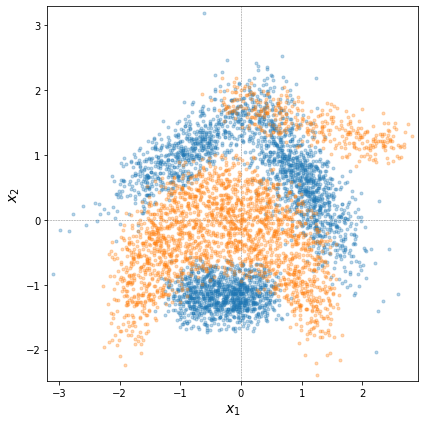

In [2]:
data = sio.loadmat('../data/banana.mat')
Y = data['banana_Y']
X = data['banana_X']
x1_lim = [np.min(X[:, 0])-0.1, np.max(X[:, 0])+0.1]
x2_lim = [np.min(X[:, 1])-0.1, np.max(X[:, 1])+0.1]

fig, ax = plt.subplots(figsize=(6, 6))
ax.axhline(0, color='k', linestyle="dashed", alpha=0.5, linewidth=.5)
ax.axvline(0, color='k', linestyle="dashed", alpha=0.5, linewidth=.5)
ax.plot(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], 'o', color="C0", ms=3, alpha=0.3, label="$y=0$")
ax.plot(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], 'o', color="C1", ms=3, alpha=0.3, label="$y=1$")
ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14)
ax.set_xlim(x1_lim)
ax.set_ylim(x2_lim)
#ax.legend(loc="upper left", fontsize=12)

plt.tight_layout()
plt.savefig("banana_data.pdf")

We now split the dataset in four, and build an SVGP model for each of them

In [3]:
# Compute masks for the four quadrants
maskNE = np.logical_and(X[:, 0] < 0, X[:, 1] >= 0) 
maskNW = np.logical_and(X[:, 0] >= 0, X[:, 1] >= 0) 
maskSE = np.logical_and(X[:, 0] < 0, X[:, 1] < 0) 
maskSW = np.logical_and(X[:, 0] >= 0, X[:, 1] < 0) 
masks = [maskNE, maskNW, maskSE, maskSW]

kernel = gpflow.kernels.Matern32(variance=50., lengthscales=[3., 3.])
gpflow.set_trainable(kernel, False)
lik = gpflow.likelihoods.Bernoulli()
mean_function = gpflow.mean_functions.Zero()

M = []
for mask in masks:
    X_ = X[mask, :]
    Y_ = Y[mask, :]
    Z = scipy.cluster.vq.kmeans(X_, 15)[0]

    m = gpflow.models.SVGP(inducing_variable=Z, likelihood=lik, kernel=kernel, mean_function=mean_function)
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(m.training_loss_closure((X_, Y_)), m.trainable_variables)
    M += [m]
    

/opt/homebrew/Caskroom/miniforge/base/envs/guepard/lib/python3.8/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
2022-07-22 16:17:29.821719: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


We can now plot the four submodels

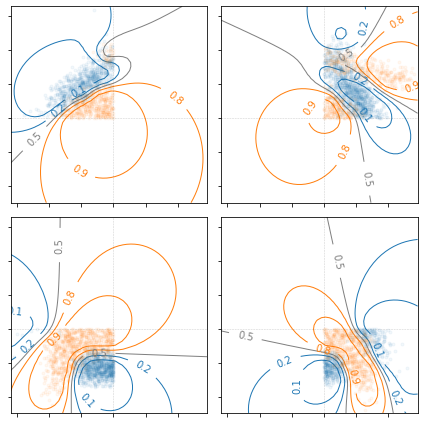

In [4]:

x1_grid = np.linspace(*x1_lim, 50)
x2_grid = np.linspace(*x2_lim, 50)
X1_grid, X2_grid = np.meshgrid(x1_grid, x2_grid) 
Xtest = np.hstack([X1_grid.reshape(-1, 1), X2_grid.reshape(-1, 1)])

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
for i in range(2):
    for j in range(2):
        k = 2 * i + j
        
        axes[i,j].axhline(0, color='k', linestyle="dashed", alpha=0.2, linewidth=.5)
        axes[i,j].axvline(0, color='k', linestyle="dashed", alpha=0.2, linewidth=.5)

        X_ = X[masks[k], :]
        Y_ = Y[masks[k], :]
        axes[i, j].plot(X_[Y_[:, 0] == 0, 0], X_[Y_[:, 0] == 0, 1], 'o', color="C0", ms=3, alpha=0.05, label="$y=0$")
        axes[i, j].plot(X_[Y_[:, 0] == 1, 0], X_[Y_[:, 0] == 1, 1], 'o', color="C1", ms=3, alpha=0.05, label="$y=1$")
    
        Ytest, _ = M[k].predict_y(Xtest)
        cs = axes[i, j].contour(X1_grid, X2_grid, np.reshape(Ytest, (50, 50)), linewidths=1, colors=["C0", "C0", "grey","C1", "C1"],
                        levels=[0.05, 0.25, 0.5, 0.75, 0.95], zorder=0)
        axes[i, j].clabel(cs, inline=1, fontsize=10, fmt='%1.1f')


        axes[i, j].set_xticks(np.arange(-3, 3))
        axes[i, j].set_yticks(np.arange(-2, 4))
        axes[i, j].axes.xaxis.set_ticklabels([])
        axes[i, j].axes.yaxis.set_ticklabels([])

plt.tight_layout()
plt.savefig("banana_submodels.pdf")

We can now use the equivalent observation framework to merge these four submodels

In [5]:
m_agg = guepard.SparseGuepard(M)
m_agg.predict_f = m_agg.predict_foo
Ytest = m_agg.predict_y(Xtest)[0]


2022-07-22 16:17:39.057264: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2022-07-22 16:17:39.098139: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


For comparison we fit an SVGP model with the same kernel, same inducing location Z, but an optimised distribution for the inducing variables.

In [ ]:
m_svgp = m_agg.get_fully_parameterized_svgp()
gpflow.set_trainable(m_svgp.inducing_variable, False)

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m_svgp.training_loss_closure((X, Y)), m_svgp.trainable_variables)

Ysvgp = m_svgp.predict_y(Xtest)[0]

NameError: name 'Ysvgp' is not defined

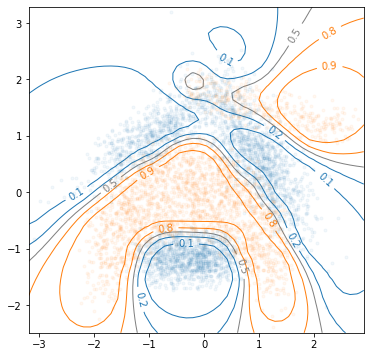

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], 'o', color="C0", ms=3, alpha=0.05, label="$y=0$")
ax.plot(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], 'o', color="C1", ms=3, alpha=0.05, label="$y=1$")


cs = ax.contour(X1_grid, X2_grid, np.reshape(Ytest, (50, 50)), linewidths=1, colors=["C0", "C0", "grey","C1", "C1"],
                        levels=[0.05, 0.25, 0.5, 0.75, 0.95], zorder=0)

ax.clabel(cs, inline=1, fontsize=10, fmt='%1.1f')

cs = ax.contour(X1_grid, X2_grid, np.reshape(Ysvgp, (50, 50)), linewidths=1, colors=["C0", "C0", "grey","C1", "C1"],
                        levels=[0.05, 0.25, 0.5, 0.75, 0.95], zorder=0, alpha=.5)


plt.plot(m_agg.inducing_variable.Z[:, 0], m_agg.inducing_variable.Z[:, 1], "ko", ms=2., alpha=.4)
ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14)
ax.set_xlim(x1_lim)
ax.set_ylim(x2_lim)

plt.tight_layout()
plt.savefig("banana_models.pdf")

we can plot the absolute error

(-2.49, 3.29)

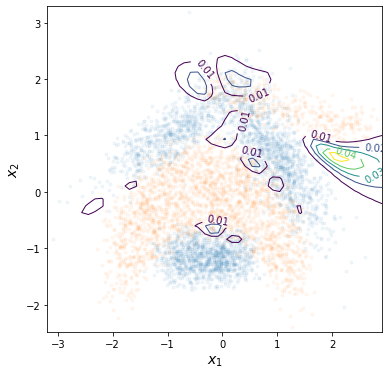

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], 'o', color="C0", ms=3, alpha=0.05, label="$y=0$")
ax.plot(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], 'o', color="C1", ms=3, alpha=0.05, label="$y=1$")

cs = ax.contour(X1_grid, X2_grid, np.reshape(np.abs(Ysvgp-Ytest), (50, 50)), linewidths=1, levels=[0.01, 0.02, 0.03, 0.04, 0.05])
ax.clabel(cs, inline=1, fontsize=10, fmt='%1.2f')

ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14)
ax.set_xlim(x1_lim)
ax.set_ylim(x2_lim)

max absolute error 0.054148165888318


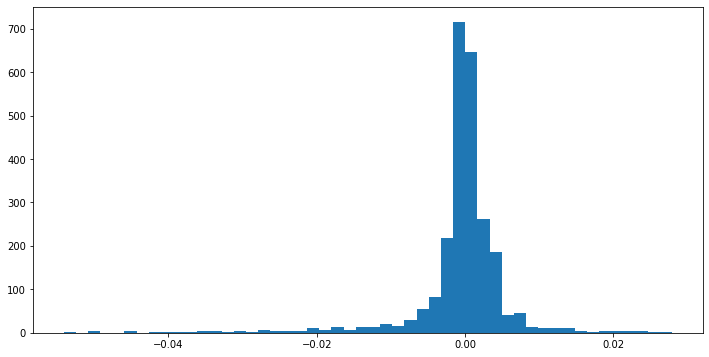

In [ ]:
error = (Ytest- Ysvgp).numpy().flatten()
plt.hist(error, 50)
print("max absolute error", np.max(np.abs(error)))
